In [1]:
import h2o, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpsmeydm4h
  JVM stdout: /tmp/tmpsmeydm4h/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpsmeydm4h/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 15 days
H2O_cluster_name:,H2O_from_python_unknownUser_nqbmpy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2]:
# Import the iris dataset into H2O:
iris = h2o.import_file("http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv")
predictors = ["sepal_len", "sepal_wid", "petal_len", "petal_wid"]
iris_df = iris.as_data_frame()
iris_df.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


,sepal_len,sepal_wid,petal_len,petal_wid,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 1. Hierarchical models via sklearn

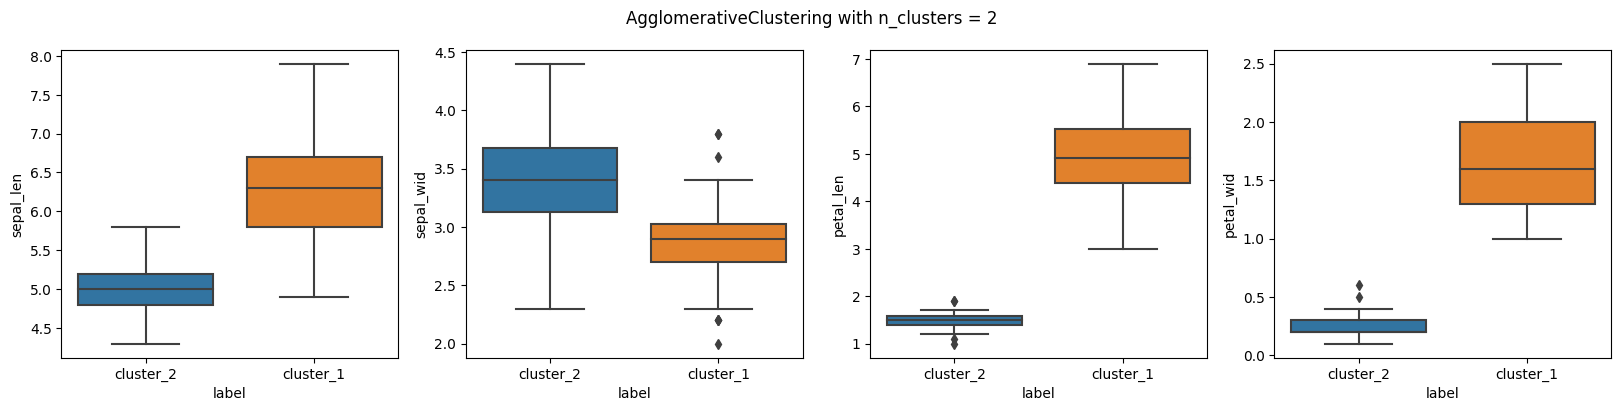

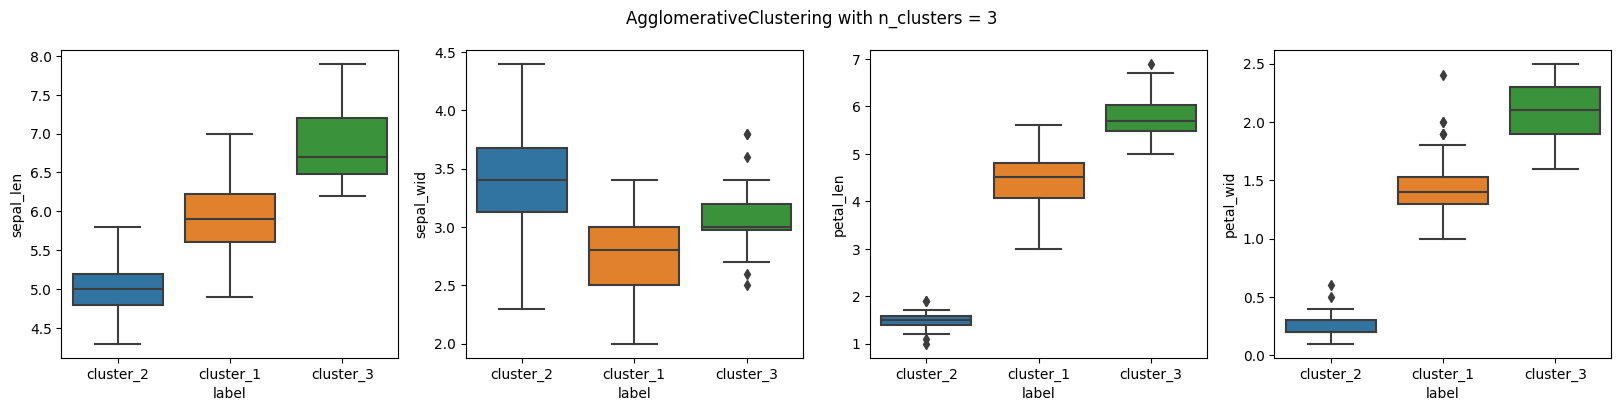

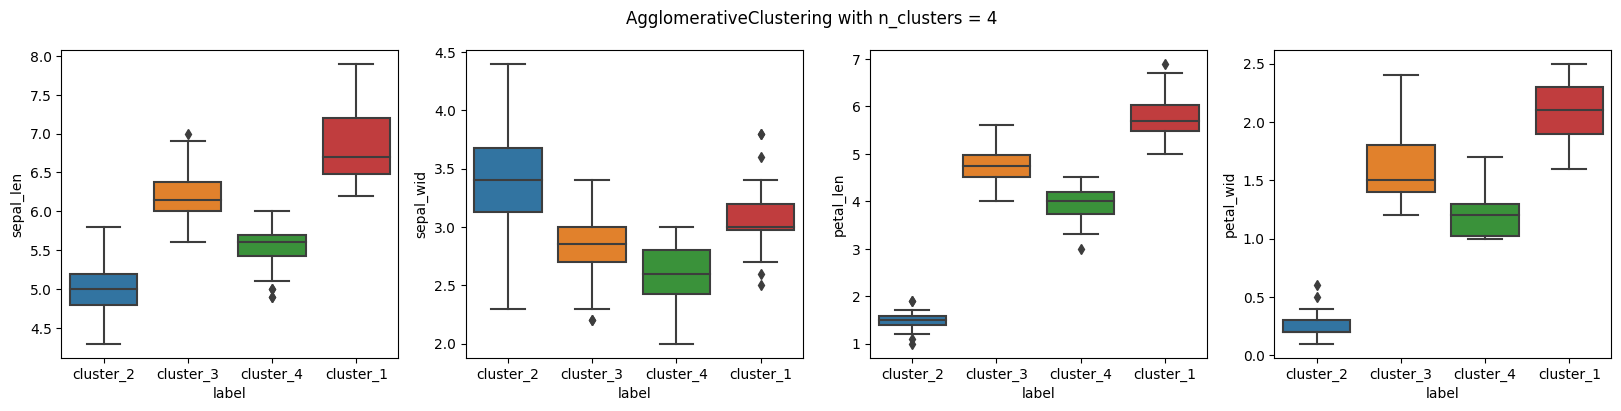

In [3]:
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration

for n_clus in [2,3,4]:
    tempdf = iris_df[predictors].copy()
    clustering = AgglomerativeClustering(n_clusters=n_clus).fit(tempdf)
    tempdf['label'] = [f"cluster_{cen+1}" for cen in clustering.labels_]
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    plt.suptitle(f"AgglomerativeClustering with n_clusters = {n_clus}")
    for idx, col in enumerate(predictors):
        sns.boxplot(tempdf, y=col, x='label', ax=ax[idx])

#### FeatureAgglomeration

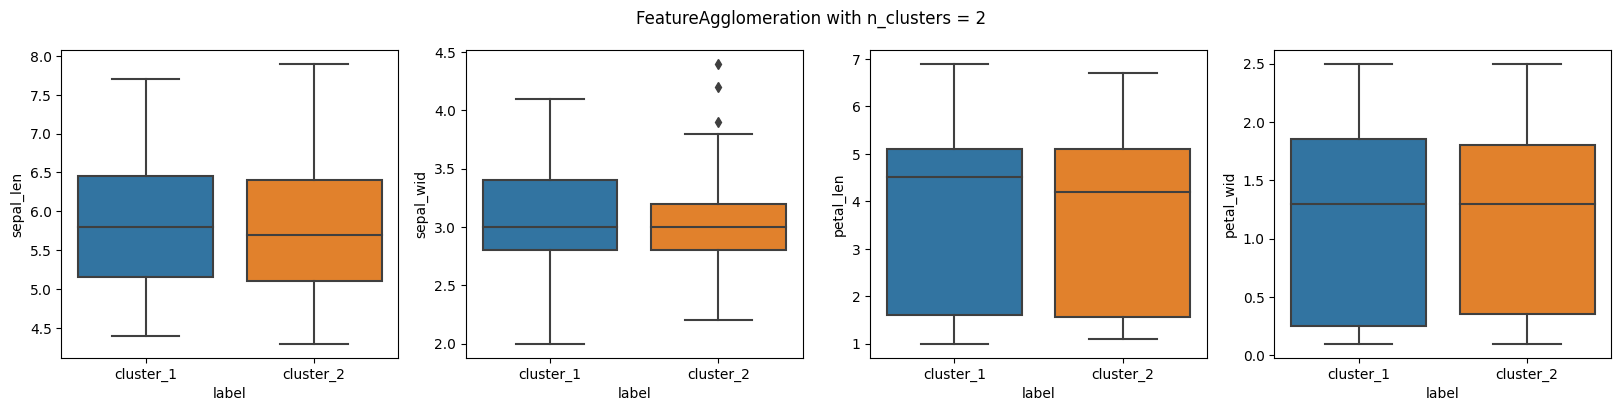

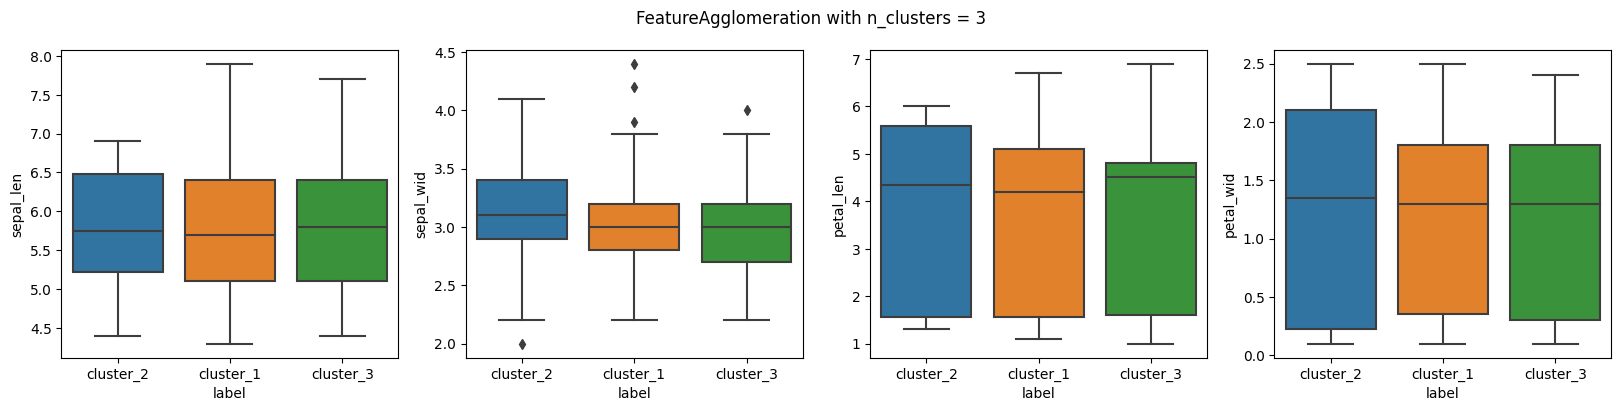

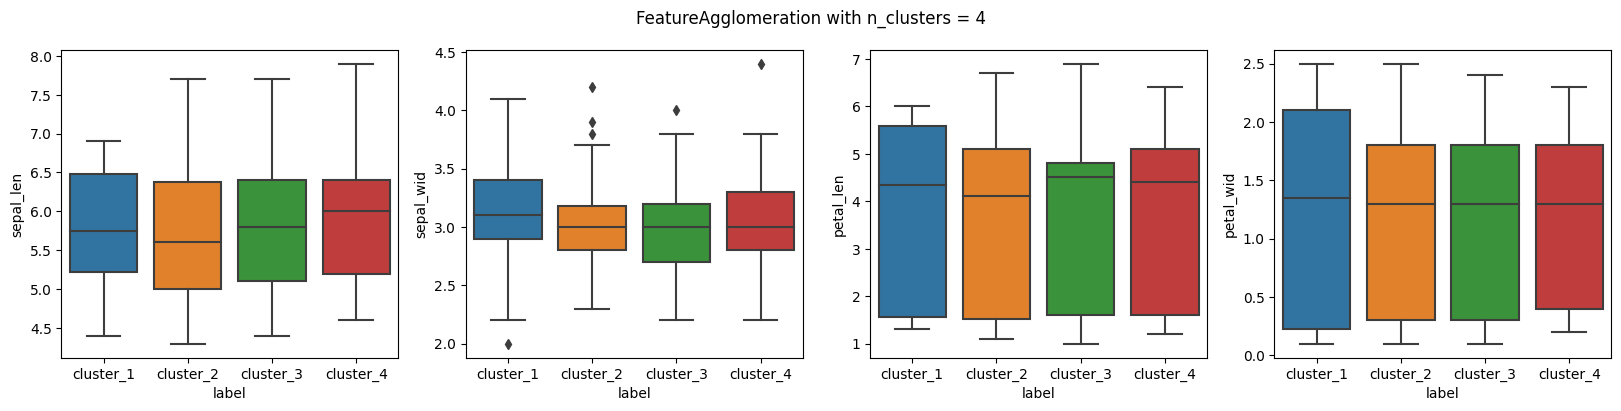

In [5]:
for n_clus in [2,3,4]:
    tempdf = iris_df[predictors].copy()
    X_trans = tempdf.to_numpy().reshape(4, -1)
    clustering = FeatureAgglomeration(n_clusters=n_clus).fit(X_trans)
    tempdf['label'] = [f"cluster_{cen+1}" for cen in clustering.labels_]
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    plt.suptitle(f"FeatureAgglomeration with n_clusters = {n_clus}")
    for idx, col in enumerate(predictors):
        sns.boxplot(tempdf, y=col, x='label', ax=ax[idx])

### Visualize the dendrogram

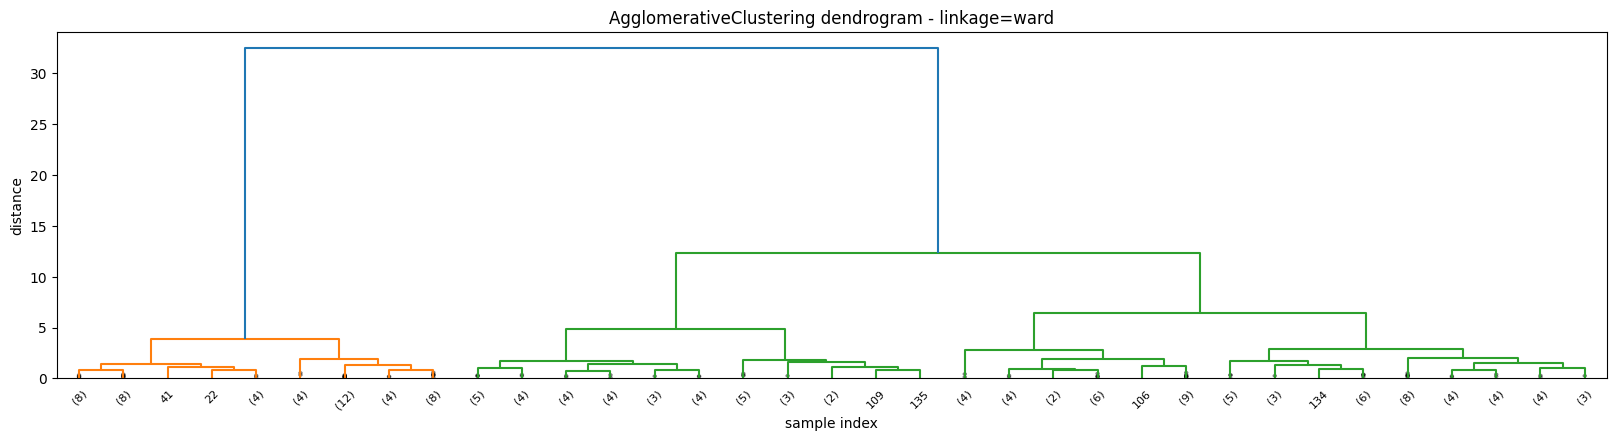

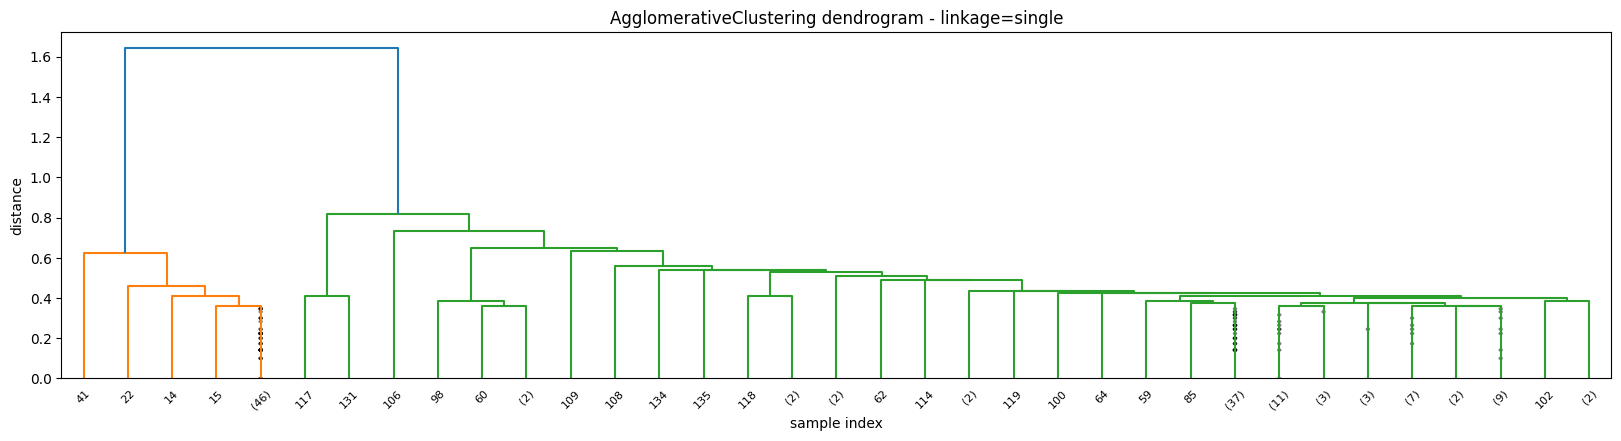

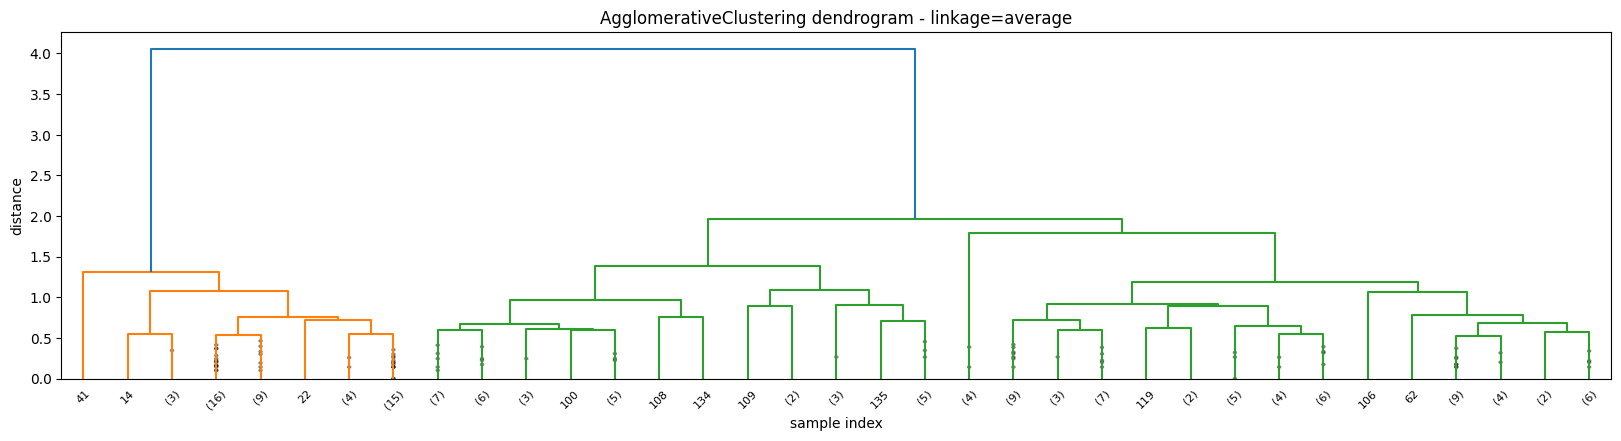

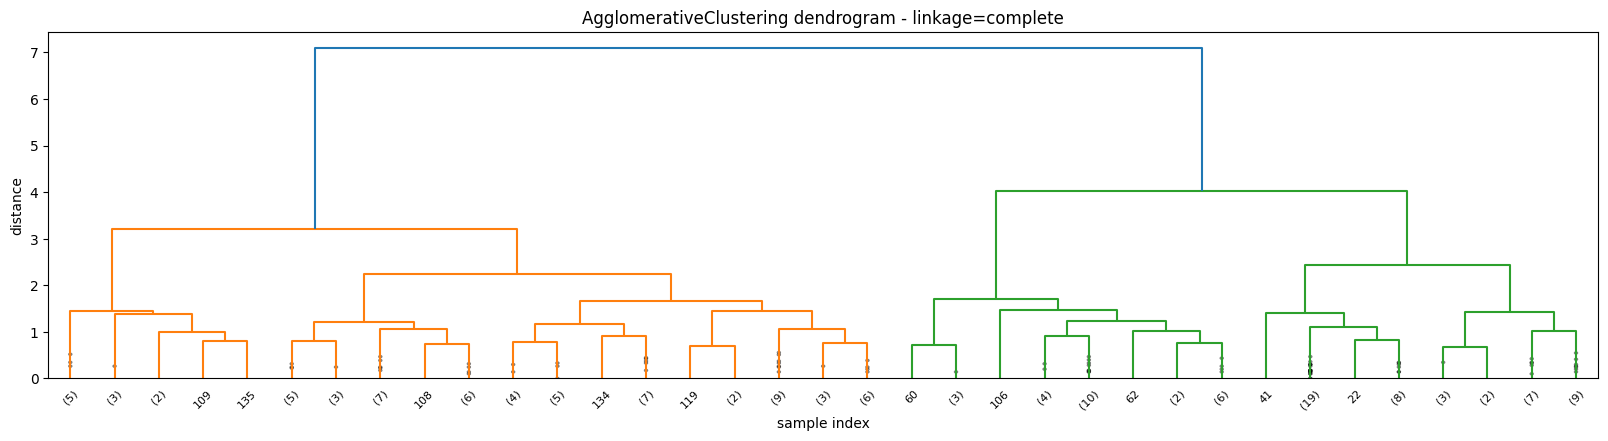

In [6]:
from scipy.cluster.hierarchy import linkage, dendrogram
for lin in ['ward', 'single', 'average', 'complete']:
    linkage_matrix = linkage(iris_df[predictors], lin)
    fig = plt.figure(figsize=(20,4.5))
    dendrogram(linkage_matrix, 
               truncate_mode='lastp',
               p = 35,
               show_contracted = True
              )
    plt.title(f"AgglomerativeClustering dendrogram - linkage={lin}")
    plt.xlabel("sample index")
    plt.ylabel("distance")
    plt.show()

By using `dendrogram` we still obtain that $k=3$ will be the most optimal clusters

## 2. [H2o - Hierarchical Linear Models](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/hglm.html)
This is not the same as the `Hierarchical model` that we presented in the previous section, noting that:
- Generalized Linear Models (GLM) estimate regression models for outcomes following exponential distributions. 
- Hierarchical GLM (HGLM) fits generalized linear models with random effects, where the random effect can come from a conjugate exponential-family distribution (for example, Gaussian). 

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


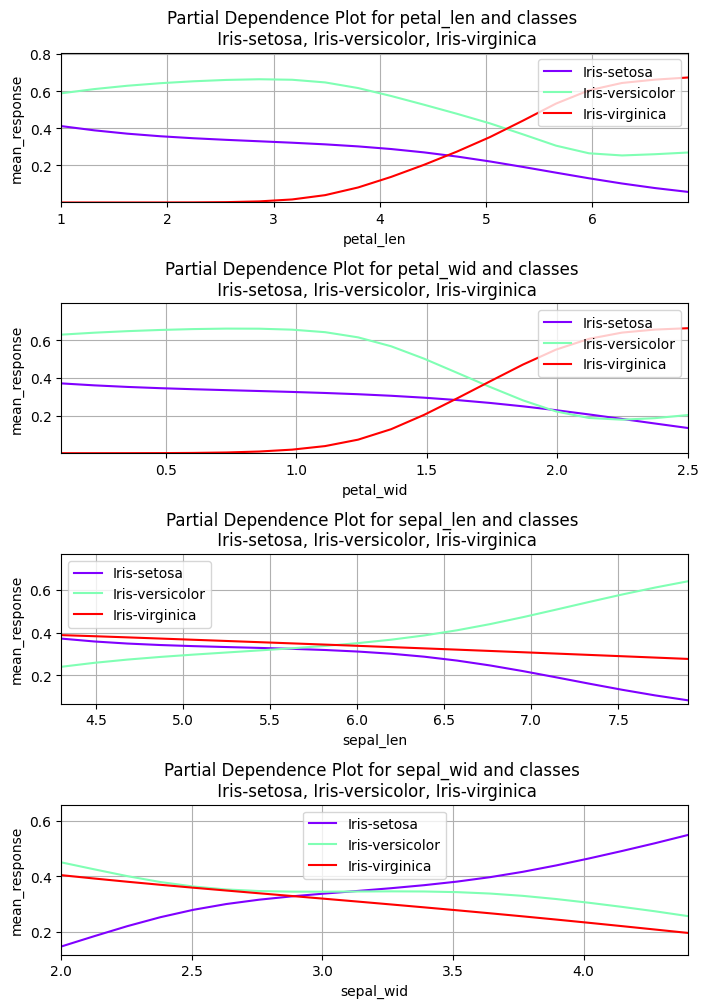

In [7]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

model = H2OGeneralizedLinearEstimator(family = 'multinomial')
model.train(x = predictors, y = 'class', training_frame = iris)
model.partial_plot(data=iris, cols=["petal_len", "petal_wid", "sepal_len", "sepal_wid"], 
                         plot_stddev=False, plot=True, 
                         targets=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
plt.show()

In [8]:
model.model_performance()

ModelMetricsMultinomialGLM: glm
** Reported on train data. **

MSE: 0.014742589738302904
RMSE: 0.12141906661765649
LogLoss: 0.05749976532342166
Null degrees of freedom: 149
Residual degrees of freedom: 136
Null deviance: 329.5836866004324
Residual deviance: 17.2499295970265
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Iris-setosa    Iris-versicolor    Iris-virginica    Error    Rate
-------------  -----------------  ----------------  -------  -------
50             0                  0                 0        0 / 50
0              48                 2                 0.04     2 / 50
0              1                  49                0.02     1 / 50
50             49                 51                0.02     3 / 150

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.98
2    1
3    1